### **Linear Neural Network**

 Deep learning is an approach to machine learning characterized by deep stacks of computations. This depth of computation is what has enabled deep learning models to disentangle the kinds of complex and hierarchical patterns found in the most challenging real-world datasets. In this notebook, i have discussed about each chapter of this **"Dive into Deep Learning"** book by Aston Zhang, Zack C. Lipton, Mu Li, and Alex J. Smola.

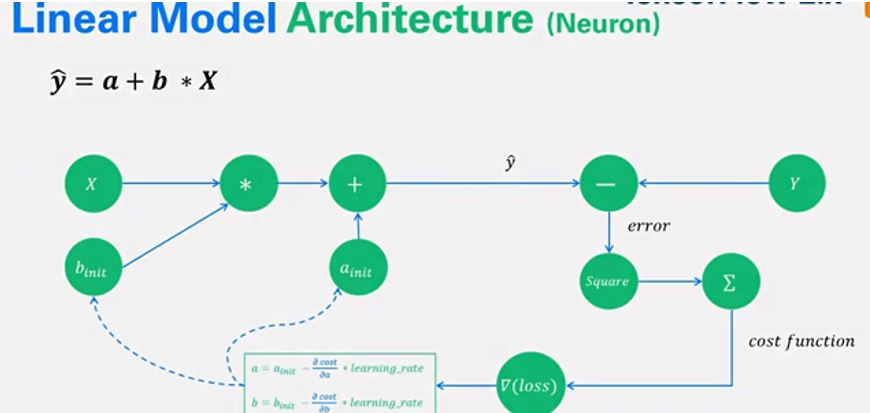

**Linear Neural network model**

* **Model**: $ \hat y = Xw + b $
* **Loss/cost function**: Measure of model fit,The loss function measures the disparity between the the target's true value and the value the model predicts.high value means worse fit and need to minimize the loss function. Common loss function are Mean squared error (MSE), Mean absolute error (MAE), Huber error.
* **optimizer**: The optimizer is an algorithm that adjusts the weights, bias to minimize the loss.
Virtually all of the optimization algorithms used in deep learning belong to a family called stochastic gradient descent. They are iterative algorithms that train a network in steps (epochs). One step of training goes like this:

1. Sample some training data and run it through the network to make predictions.
2. Measure the loss between the predictions and the true values.
3. Finally, adjust the weights in a direction that makes the loss smaller.

Each iteration's sample of training data is called a **minibatch** (or often just **"batch"**), while a complete round of the training data is called an **epoch.** The number of epochs you train for is how many times the network will see each training example.

**Learning Rate Batch:** The size of shifts (weights and bias) is determined by the learning rate. A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.

some optimizer are gradient descent(SGD), Adaptive moment (adam) optimizer
Minibatch SGD Optimizer.





**The artificial dataset produce**

In [8]:
# import requried library
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
from d2l import tensorflow as d2l

In [10]:
def synthetic_data(w, b, num_examples): 
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0])) # define  a 1000 X 2 constant, constant is not trainable
    X += tf.random.normal(shape=X.shape) # a 1000 X 2 filled with values from a normal distribution
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b # matrix mulplication perform 
    y += tf.random.normal(shape=y.shape, stddev=0.01) # additive noise obeying normal distribution
    y = tf.reshape(y, (-1, 1))
    return X, y

In [11]:
# true parameters for generating dataset
true_w = tf.constant([2, -3.4]) # 1D tensor
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
#print(len(features))
#print(true_w.numpy())
# print(true_w)
# x= tf.reshape(w,(-1,1))
# print(x)
#x = tf.zeros((1000,2))

In [13]:
print('features:', features[0], '\nlabel:', labels[0]) # create two features and 1 target

features: tf.Tensor([ 2.286295 -0.501926], shape=(2,), dtype=float32) 
label: tf.Tensor([10.467044], shape=(1,), dtype=float32)


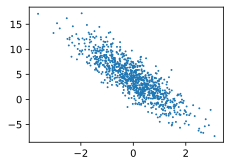

In [14]:
# relationship between second features and lable
# note the linear correlation
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

**Reading the Dataset**
shuffle and load minibatches.

Advantage of minibatches data instead of full sample
1. Multiple updates per epoch
2. Requires division of dataset
3. No limit on dataset size

In [15]:
# create a function to read data, but it's not a efficient way
def data_iter(batch_size, features, labels):
    num_examples = len(features)   # here 1000
    indices = list(range(num_examples)) # create a list of 1000 features
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j) #Gather slices from params axis according to indices

In [16]:
# examples of a batch, here total data sample = 1000, from then take 10 sample
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 2.7642694  -0.50528723]
 [ 0.10896883  0.9272137 ]
 [-0.30371246 -0.7109913 ]
 [-1.226805   -0.89794487]
 [-0.2787461  -0.4146732 ]
 [-1.0221982   0.41721448]
 [-1.0897955  -0.14029633]
 [-0.6362112   0.61930406]
 [ 1.1618145   0.00631612]
 [-0.49720597  0.44578224]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[11.432802  ]
 [ 1.2553226 ]
 [ 6.0171657 ]
 [ 4.8078966 ]
 [ 5.058771  ]
 [ 0.74306536]
 [ 2.5084682 ]
 [ 0.8065034 ]
 [ 6.498537  ]
 [ 1.6802555 ]], shape=(10, 1), dtype=float32)


**Comment:** It is not an efficient implementation of iterating through the data as it performs lots of random memory access.

### **Initialize Model Parameters**
The parameters will be updated to fit the data. 
First, compute the gradient of the loss function with
respect to the parameters. Use those gradients to update
the parameters in the direction that reduce the loss.

**Any model consists 5 basic steps:**

1.   Define Model parameters (weights, bias)
2. Define Model
3. Define loss function
4. Define optimizer
5. training the model
6. Evalution





In [17]:
# initialize weights by sampling random numbers from a normal distribution with 
# mean 0 and a standard deviation of 0.01, and setting the bias to 0, the bias to 0 at initial
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True) # track computation

In [18]:
print(w) # to check the initial value
print(b)

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[-0.00886222],
       [ 0.01451855]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


### **Defining the model**

$ \hat y = Xw + b $

In [19]:
# crate a function for linear regression model, y = Xw + b
def linreg(X, w, b):  
    """The linear regression model."""
    return tf.matmul(X, w) + b

Using broadcasting, the `b` values are added to each component in the resulting vector from the matrix-vector dot product, `Xw`.

### **Defining the loss function**
sum of square error,
sse = $ \sum(y_t - y_p)^2 $

In [20]:
# create a loss function
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape))**2 / 2

### **Defining the Optimization algorithm**

Here i used Minibatch stochastic gradient descent and  read the referrence book and follwing blog to understand the minibatch SGD optimizer

1. https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

Another SGD optimizer is Adaptive moment (adam) optimizer that performs well with default parameter values. Adam is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning.

In [21]:
def sgd(params, grads, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad / batch_size) # assign_sub is used subtract values

**Comment:** normalization of batch_size which is the size of the batches. Removes depedence of batch size on the step size.

### **Training/ fitting the model**

step to train the model
1. Initialize parameters again
2. Repeat until done:

* Compute gradients
* Update parameters








In [22]:
lr = 0.03   # learning rate
num_epochs = 3 # number of step that want to execute
net = linreg  # model
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        dw, db = g.gradient(l, [w, b])  # Compute gradient on l with respect to [`w`, `b`]
        sgd([w, b], [dw, db], lr, batch_size) # Update parameters using their gradient
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.035784
epoch 2, loss 0.000130
epoch 3, loss 0.000047


Compare the true parameters with the ones learned

In [23]:
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [ 3.5762787e-07 -9.5486641e-04]
error in estimating b: [0.00086641]


### **3.3 Implementation of Linear Regression using keras sequential API**

**keras sequential API:** The easiest way to create a model in Keras is through keras.Sequential, which creates a neural network as a stack of layers. But sharing of layers or branching of layers is not allowed
**keras Functional API:** It is more flexible than the sequential API. It is more powerful than the sequential API in the sense branching or sharing of layers is allowed here. And also it can have multiple inputs and outputs.



In [25]:
# generating dataset
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [26]:
print(len(features))
print(len(labels))

1000
1000


In [27]:
# read dataset
def load_array(data_arrays, batch_size, is_train=True):
  """Construct a TensorFlow data iterator."""
  dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
  if is_train:
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset 

In [28]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [29]:
next(iter(data_iter))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 0.75174147, -0.8777986 ],
        [-0.53580105, -0.2401035 ],
        [-1.2279407 , -0.11282917],
        [-0.4408528 ,  0.8564064 ],
        [ 2.0029616 ,  1.6031181 ],
        [-1.3460803 ,  0.11740587],
        [-1.3914623 ,  1.0183742 ],
        [-0.23763467, -0.44749686],
        [-0.5748012 , -0.35654166],
        [ 1.7922397 ,  0.15695834]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 8.691415  ],
        [ 3.9348066 ],
        [ 2.118958  ],
        [ 0.40191245],
        [ 2.7553437 ],
        [ 1.1134666 ],
        [-2.038353  ],
        [ 5.2576904 ],
        [ 4.262624  ],
        [ 7.267419  ]], dtype=float32)>)

In [30]:
# defining the model
# `keras` is the high-level API for TensorFlow
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1))

In [31]:
# initializing the model parameters (w, b)standard deviation of 0.01, and setting the bias to 0,at initial.
# here initiallize means w, b
initializer = tf.initializers.RandomNormal(stddev=0.01)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

In [32]:
# loss function
loss = tf.keras.losses.MeanSquaredError()

In [33]:
# defining the optimization
optimize = tf.keras.optimizers.SGD(learning_rate=0.03)

In [34]:
# training
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:  # X features, y labels
        with tf.GradientTape() as g:
            l = loss(model(X, training=True), y)
        grads = g.gradient(l, model.trainable_variables) # traniable_variables here is w,b and grads consists dw,db
        optimize.apply_gradients(zip(grads, model.trainable_variables)) # update parameters
    l = loss(model(features), labels) # features, labels take from data_iter
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000242
epoch 2, loss 0.000095
epoch 3, loss 0.000094


In [35]:
var = model.get_weights()
print(var)

[array([[ 2.0003376],
       [-3.3996782]], dtype=float32), array([4.200518], dtype=float32)]


In [36]:
# comapre the true parameters with the ones learned
w = model.get_weights()[0]
print('error in estimating w', true_w - tf.reshape(w, true_w.shape))
b = model.get_weights()[1]
print('error in estimating b', true_b - b)

error in estimating w tf.Tensor([-0.0003376  -0.00032187], shape=(2,), dtype=float32)
error in estimating b [-0.00051832]


**Comment:** here actual value of the weights (w) is [2, -3.4 ]and predicted value is [1.9999583, -3.40050720] and bias value actual is 4.2 and predicted value after training is [4.1993213]

In [37]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


**Next-work:**  Here i have read thoroughly the basic linear neural network that described in the book. I covered topics from the book are Linear regression, Linear regression Implementation from scratch, coincise Implementation of Linear regression. Next i will do about softmax regression an activation function which is used  when output layer(>2 classes) and will work on MNIST image dataset

**References:**
1. Reference BOOK D2l: https://d2l.ai/chapter_linear-networks/linear-regression.html
1. https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
2. https://www.youtube.com/watch?v=CqOfi41LfDw&list=PLblh5JKOoLUIxGDQs4LFFD--41Vzf-ME1
3. https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/
4. https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/ 